In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
from scipy.optimize import curve_fit
import scipy.signal as scs
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Set the style of seaborn for better looking plots
sns.set()

# Data

In [2]:
ts = pd.read_csv('Reykjavik.csv')
ts

,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),...,sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),et0_fao_evapotranspiration (mm)
0,1/1/40,73,2.2,-1.7,0.3,-3.2,-6.8,-4.8,1940-01-01T11:18,1940-01-01T15:42,...,NaN,NaN,NaN,NaN,11,22.3,NaN,73,NaN,NaN
1,1/2/40,73,1.0,-0.4,0.3,-4.0,-5.9,-4.9,1940-01-02T11:17,1940-01-02T15:44,...,0.00,3.7,0.1,2.52,23,19.8,39.6,77,0.09,0.44
2,1/3/40,73,4.0,-0.4,1.9,1.2,-6.3,-3.1,1940-01-03T11:16,1940-01-03T15:46,...,0.00,5.0,1.2,2.66,16,30.0,54.0,102,0.10,0.27
3,1/4/40,53,5.4,1.5,2.5,1.5,-2.1,-1.3,1940-01-04T11:15,1940-01-04T15:48,...,828.68,2.1,2.1,0.00,12,21.1,27.7,150,0.20,0.02
4,1/5/40,55,6.5,4.6,5.6,1.8,0.2,1.2,1940-01-05T11:13,1940-01-05T15:50,...,0.00,5.5,5.5,0.00,11,29.9,52.9,148,0.16,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30950,9/26/24,3,5.1,-1.1,2.4,2.2,-4.2,-0.5,2024-09-26T07:23,2024-09-26T19:12,...,13904.13,0.0,0.0,0.00,0,9.4,20.2,318,5.18,0.60
30951,9/27/24,51,7.2,3.6,5.2,5.1,1.2,3.1,2024-09-27T07:26,2024-09-27T19:09,...,4209.56,1.1,1.1,0.00,11,11.8,21.2,92,4.15,0.56
30952,9/28/24,53,5.9,3.8,5.0,2.7,-0.1,1.4,2024-09-28T07:29,2024-09-28T19:05,...,0.00,4.2,4.2,0.00,16,16.8,31.7,103,1.70,0.45
30953,9/29/24,53,8.0,2.1,5.3,6.1,-1.6,2.1,2024-09-29T07:32,2024-09-29T19:02,...,7455.96,4.4,4.4,0.00,13,17.3,32.4,66,3.90,0.52


In [15]:
num_years = 84
temp_mean = ts['temperature_2m_mean (°C)'].iloc[:num_years*365]
t = ts['time']
t_90s= [t[i][:-2]+str(1900+ int(t[i][-2:])) for i in range(365*60+14)]
t_20s= [t[i][:-2]+str(2000+ int(t[i][-2:])) for i in range(365*60+15,len(t))]
time = t_90s + t_20s
time = time[:num_years*365]
time = pd.to_datetime(time)

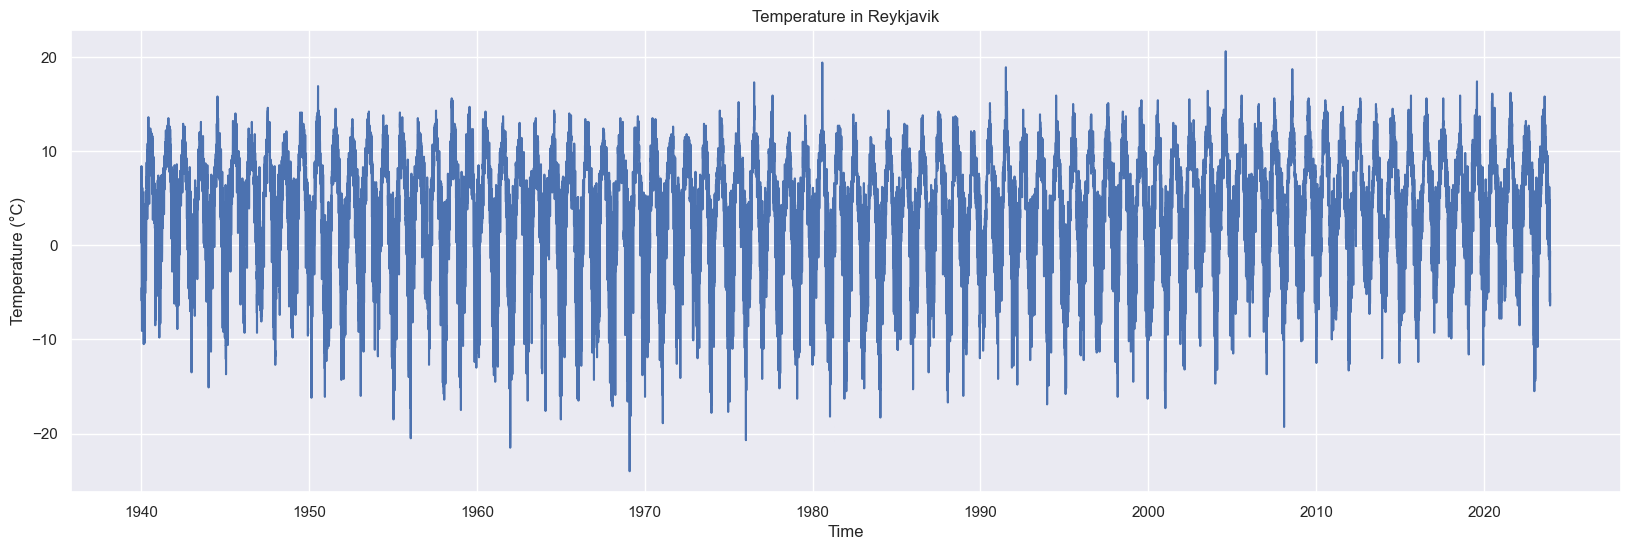

In [4]:
# Plot the time series, grouped by year on the x axis
plt.figure(figsize=(20, 6))
plt.plot(time, temp_mean)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in Reykjavik')
plt.show()

# Trend Estimation with MA filter

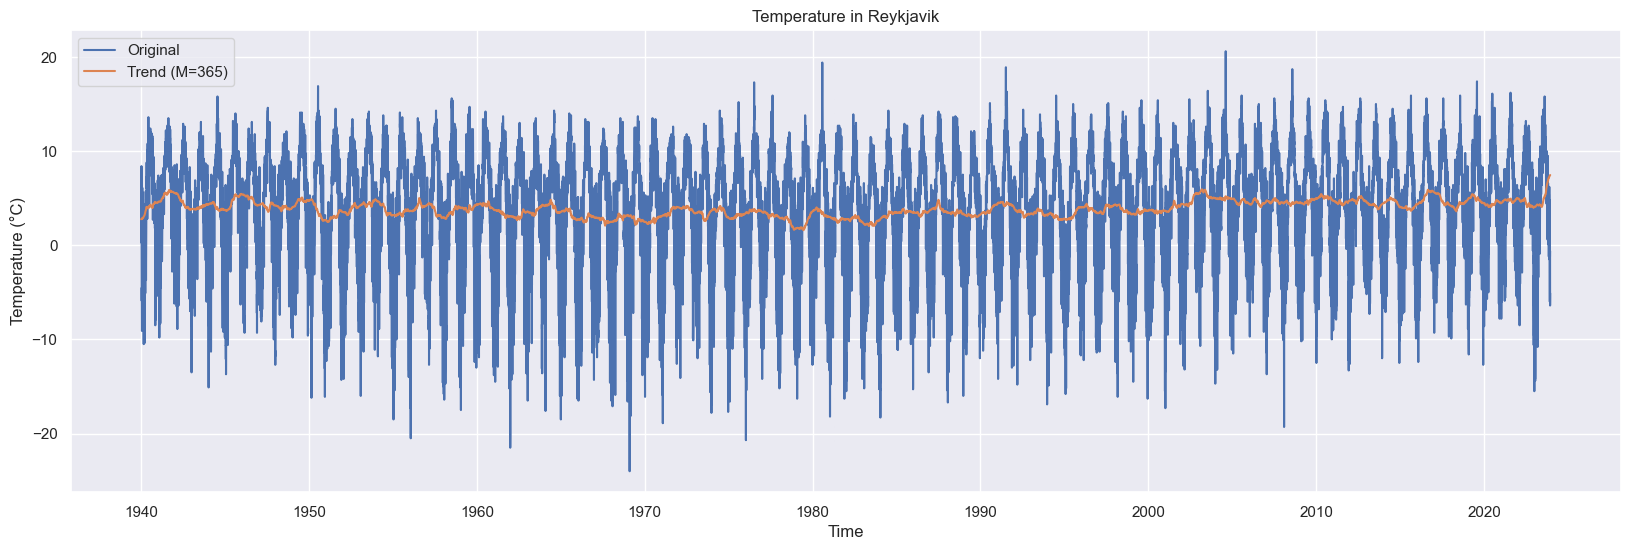

In [5]:
def maSmooth(TSeries,omega,data_aug=False):
    M=omega.shape[0]
    lag=int(np.floor((M-1)/2))
    
    if data_aug: #If smooted TS should have the same number of samples
        #TSeriesAug=TSeries._append(np.flip(TSeries[-lag:]))
        TSeriesAug=pd.concat([TSeries,np.flip(TSeries[-lag:])])
        TSeriesAug=pd.concat([np.flip(TSeries[0:lag]),TSeriesAug])
        #TSeriesAug=np.flip(TSeries[0:lag]).append(TSeriesAug)
        
    else:
        TSeriesAug=TSeries
        
    nf=range(lag,TSeriesAug.size-lag)
    xf=np.zeros(TSeriesAug.size-2*(lag)).astype('float')
    for n in nf:
        xf[n-lag]=(1/float(sum(omega)))*np.sum(np.multiply(TSeriesAug[n-lag:n+lag+1],omega))
    xf=pd.Series(data=xf, index=TSeriesAug.index[lag:TSeriesAug.size-lag],name="Smoothed TS with M="+str(M))
    
    return xf

# Define the moving average filter
M = 365
omega = np.ones(M) * (1 / float(M))

# Apply the moving average filter
Trend = maSmooth(temp_mean, omega, data_aug=True)
temp_mean_no_trend = temp_mean - Trend

# Plot the original time series and the smoothed time series
plt.figure(figsize=(20, 6))

# Plot original time series
plt.plot(time, temp_mean, label='Original')

# Adjust the time index for the smoothed series
#lag = int(np.floor((M - 1) / 2))
#adjusted_time = time[lag:-lag]  # Adjust time to match smoothed series length

# Plot the smoothed time series with the adjusted time index
plt.plot(time, Trend, label='Trend (M=365)')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in Reykjavik')
plt.legend()
plt.show()



# Trend Estimation with LOWESS

/tmp/ipykernel_19882/2389570989.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xf[k]=res_wls.params[1]*k+res_wls.params[0]


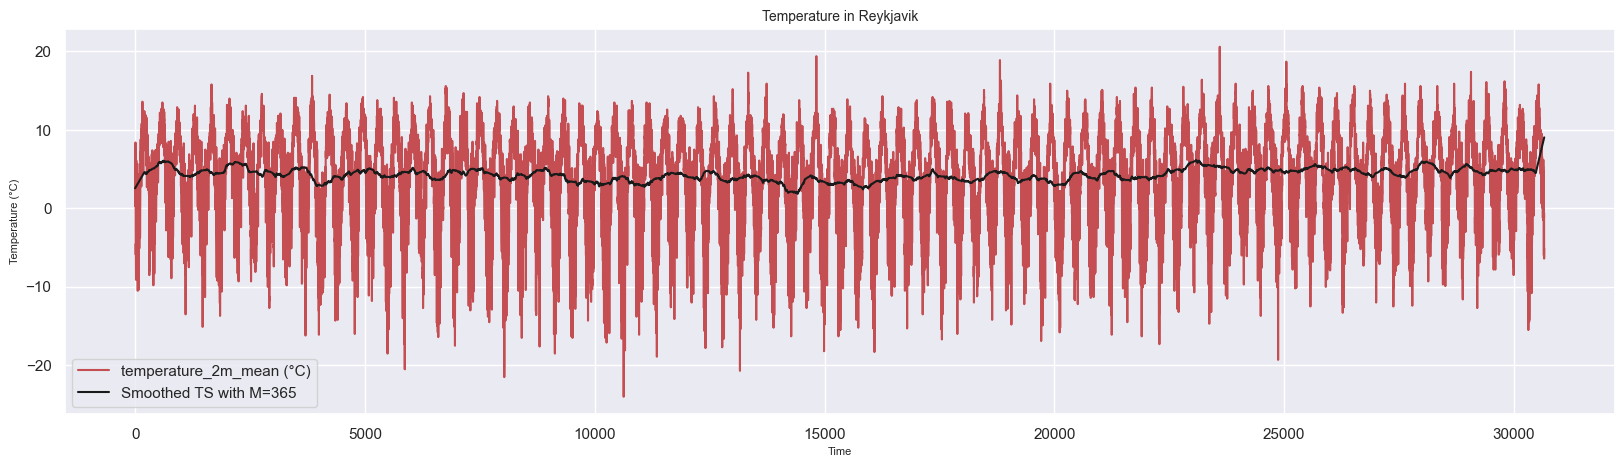

In [ ]:
def flin(x,a,b):
    return a*x+b

def xWeights(x,xi,span):
    wi=(1-abs((x-xi)/float(span))**3)**3
    #plt.figure()
    #plt.plot(wi)
    return wi

def yWeights(ri,MAD):
    if np.abs(ri)<6*MAD:
        return (1-((ri/(6*MAD))**2))**2
    else:
        return 0


def loessPass(TSeries,TSeriesE=pd.Series(np.array([])),span=5,timePass=True):
    lag=int((span-1)/2)
    xf=np.zeros(TSeries.size).astype('float')
    for k in range(TSeries.size):
        if k<=lag:
            win=TSeries[0:span]
            if not timePass:
                winE=TSeriesE[0:span]
            xvs=np.array(range(span))
            #print "No inicio"
        elif k>TSeries.size-lag:
            #print "No fim"
            win=TSeries[TSeries.size-span:TSeries.size]
            if not timePass:
                winE=TSeriesE[TSeriesE.size-span:TSeriesE.size]
            xvs=np.array(range(TSeries.size-span,TSeries.size))
        else:
            #print "No meio"
            win=TSeries[k-lag-1:k+lag]
            if not timePass:
                winE=TSeriesE[k-lag-1:k+lag]
            xvs=np.array(range(k-lag,k+lag+1))

        ws=np.zeros(span).astype('float')
            
        if not timePass:
            res=np.array(win-winE)
            #res=res.as_matrix()
            MAD=np.median(np.abs(res))
            
        for xw in range(len(xvs)):
            if timePass:
                ws[xw]=xWeights(k,xvs[xw],np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1]))))
            else:
                ws[xw]=yWeights(res[xw],MAD)
            #print np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1])))
        exog = sm.add_constant(xvs)
        
        
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        
        xf[k]=res_wls.params[1]*k+res_wls.params[0]
    return xf

def lowess(TSeries,span=5,ftype='linear'):
    
    xf=loessPass(TSeries,span=span,timePass=True)
    xf=loessPass(TSeries,TSeriesE=pd.Series(data=xf, index=TSeries.index),span=span,timePass=False)
    xf=pd.Series(data=xf, index=TSeries.index,name="Smoothed TS with M="+str(M))
    return xf


# apply smooth 13 
M=365
Trend = lowess(temp_mean,span=M)
temp_mean_no_trend = temp_mean - Trend
# Create a new figure with a specific size (width, height)
fig, ax = plt.subplots(figsize=(20, 5))  # Adjust the width as needed

temp_mean.plot(ax=ax, color='r', legend=True)
Trend.plot(ax=ax, color='k', legend=True)
ax.set_ylabel('Temperature (°C)', fontdict={'fontsize':8})
ax.set_xlabel('Time', fontdict={'fontsize':8})
ax.set_title('Temperature in Reykjavik', fontdict={'fontsize':10})

plt.show()

# Seasonality Estimation Butter Filter

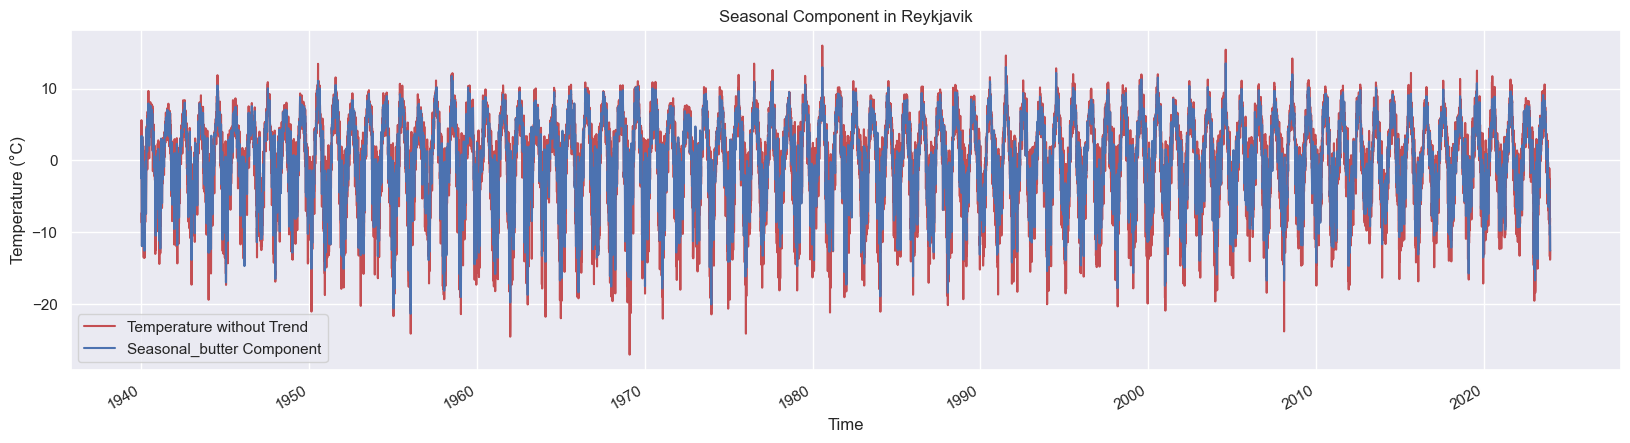

In [42]:
# Estimate the seasonal component with butter filter
sos=scs.butter(N=5,fs=12,Wn=[1.4],btype='lowpass',output='sos')
Seasonal = scs.sosfiltfilt(sos,temp_mean_no_trend)

# Create a new figure with a specific size (width, height)
fig, ax = plt.subplots(figsize=(20, 5))  # Adjust the width as needed

Seasonal_butter = pd.Series(data=Seasonal,index=time,name="Seasonal_butter Component")
temp_mean_no_trend = pd.Series(data=temp_mean_no_trend.values,index=time,name="Temperature without Trend")
temp_mean_no_trend.plot(ax=ax, color='r', legend=True)
Seasonal_butter.plot(legend=True)
# plot temp_mean_no_trend
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Seasonal Component in Reykjavik')
plt.show()

# Remove seasonal component from temp_mean_no_trend
temp_mean_no_trend_no_season = temp_mean_no_trend - Seasonal_butter



# Seasonalty by Epoch Averaging

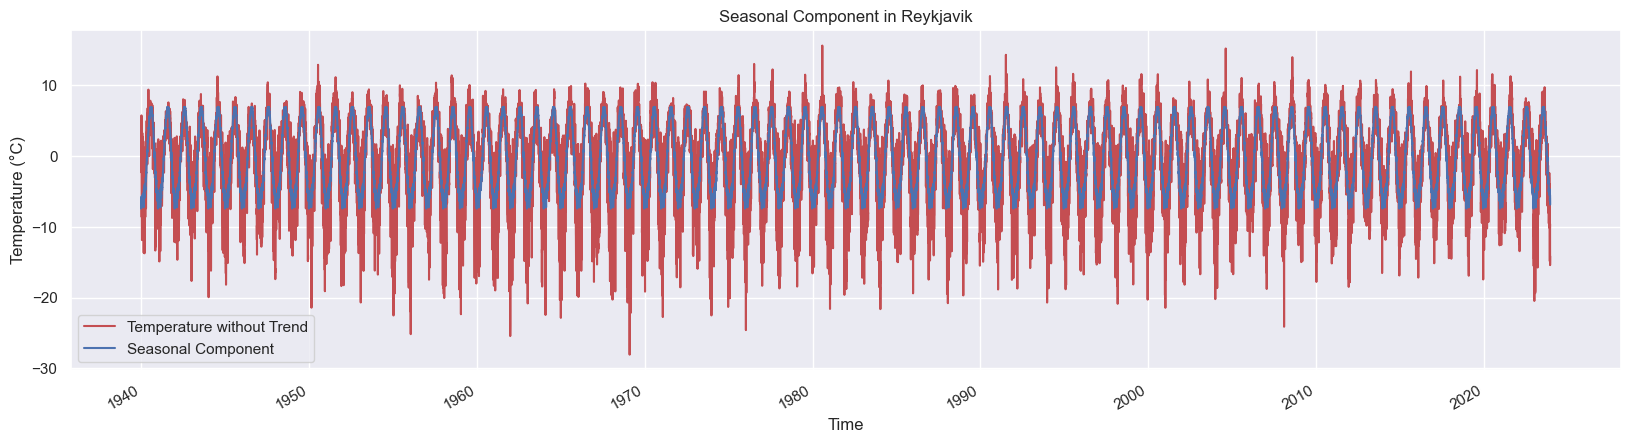

Text(0.5, 0, 'Time (Years)')

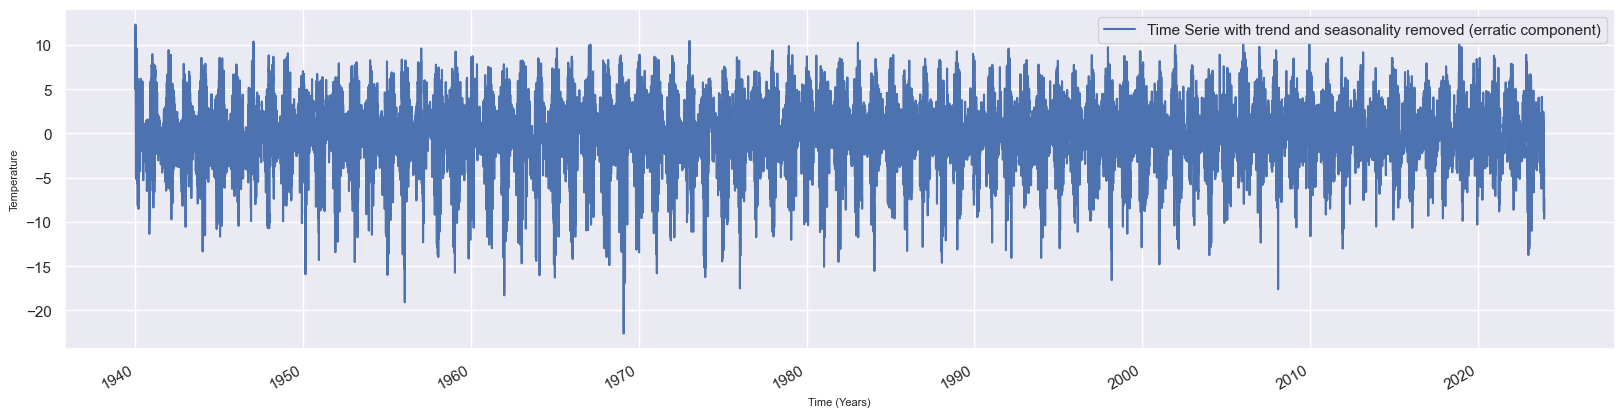

In [9]:
S=365

N=temp_mean_no_trend.size

C=int(np.floor(N/S))

reshTS=np.array(temp_mean_no_trend).reshape((C,S)) #Reshape 1 column per month

ac=np.tile(np.mean(reshTS,axis=0),(C,))
temp=temp_mean_no_trend[0:C*S]
SeaTS=pd.Series(data=ac,index=temp_mean_no_trend.index,name="Seasonal Component")
fig, ax = plt.subplots(figsize=(20, 5))
# plot temp and seasonal component in the same plot
temp.plot(ax=ax, color='r', legend=True)
SeaTS.plot(legend=True)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Seasonal Component in Reykjavik')
plt.show()

#Remove seasonal component by assuming the additive model
psNoTrendNoSeas=temp-SeaTS
psNoTrendNoSeas.name="Time Serie with trend and seasonality removed (erratic component)"

fig, ax = plt.subplots(figsize=(20, 5))
ax=psNoTrendNoSeas.plot(legend=True)
ax.set_ylabel('Temperature',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})

# Residual component

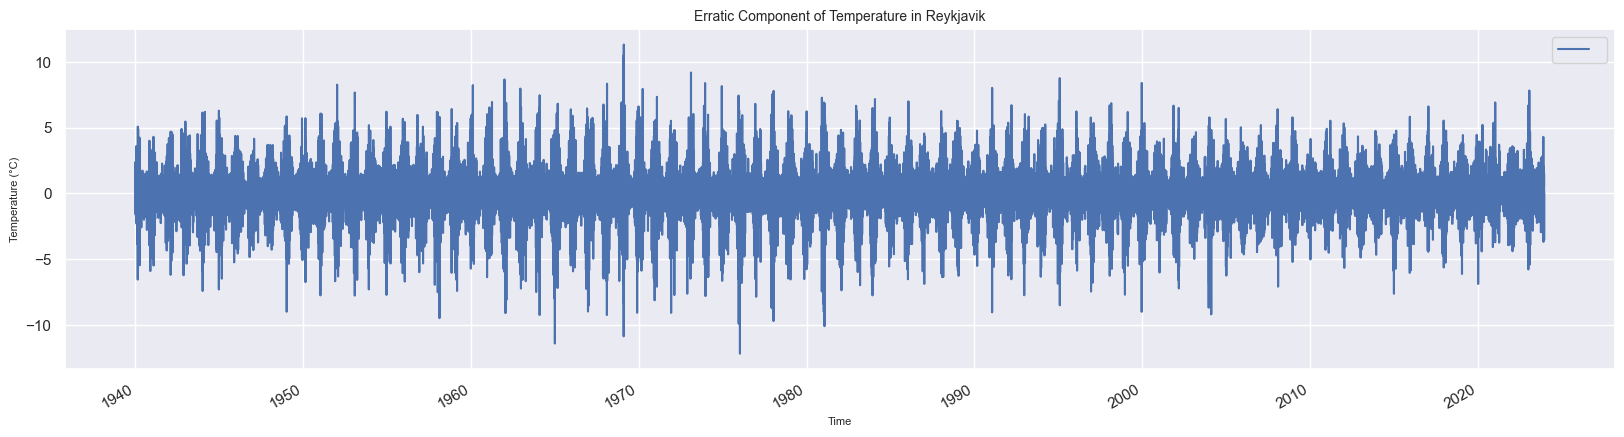

In [10]:
# Create a new figure with a specific size (width, height)
fig, ax = plt.subplots(figsize=(20, 5))  # Adjust the width as needed

temp_mean_no_trend_no_season.plot(ax=ax, color='b', legend=True)
ax.set_ylabel('Temperature (°C)', fontdict={'fontsize':8})
ax.set_xlabel('Time', fontdict={'fontsize':8})
ax.set_title('Erratic Component of Temperature in Reykjavik', fontdict={'fontsize':10})

plt.show()

# Autocorrelation Mean Temperature

In [107]:
# Get autocorrelation of temp_mean
def autocov(timeserie,T=0):
    N=timeserie.size
    mu=timeserie.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)
    return covCoef/float(N - T)
        

def autocoef(timeserie,T=0):
    return autocov(timeserie,T)/autocov(timeserie, T=0)

def correlogram(timeserie, maxT, twoside=False):
    N = timeserie.size
    if twoside:
        corrl = np.zeros(2 * maxT + 1)
        ix = np.arange(-maxT, maxT + 1)  # Symmetric indices
    else:
        corrl = np.zeros(maxT + 1)
        ix = np.arange(maxT + 1)  # Single-sided indices

    for i in range(maxT + 1):
        corrl[maxT + i if twoside else i] = autocoef(timeserie, i)  # Handle index

    # Confidence intervals
    ups = np.ones(len(ix)) * (1.96 / np.sqrt(N))
    dns = -np.ones(len(ix)) * (1.96 / np.sqrt(N))

    # DataFrame output
    corrl_df = pd.DataFrame({'ACS': corrl, 'upsig': ups, 'dnsig': dns}, index=ix)
    return corrl_df



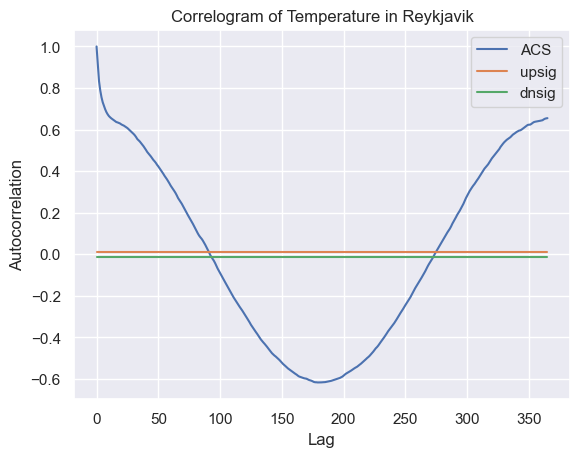

/tmp/ipykernel_19882/1577828388.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)


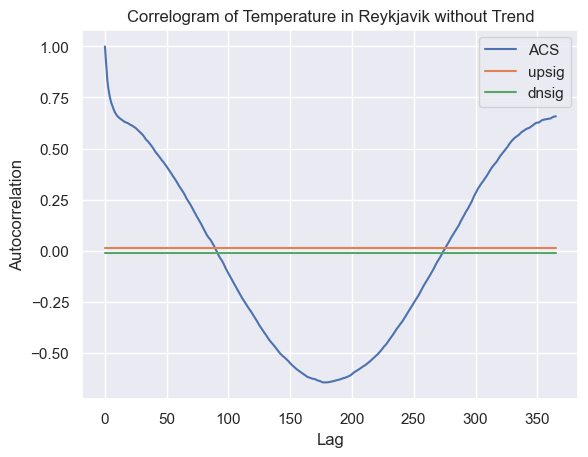

/tmp/ipykernel_19882/1577828388.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)


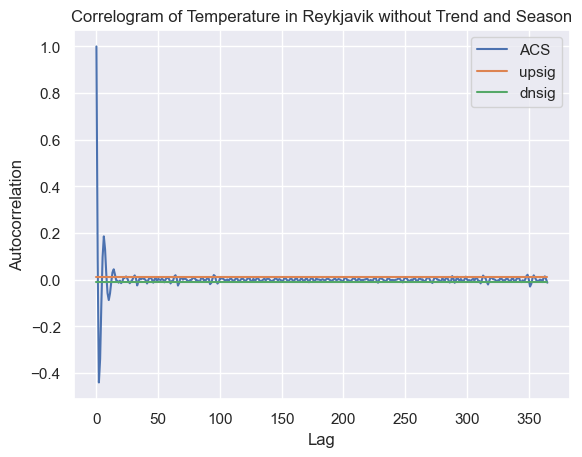

In [14]:
# Get autocorrelation of temp_mean
def autocov(timeserie,T=0):
    N=timeserie.size
    mu=timeserie.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)
    return covCoef/float(np.abs(N))
        

def autocoef(timeserie,T=0):
    return autocov(timeserie,T)/autocov(timeserie)

def correlogram(timeserie,maxT,twoside=False):
    N=timeserie.size
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            corrl[i+maxT]=autocoef(timeserie,i)
            if i>0:
                corrl[maxT-i]=corrl[i+maxT]
        else:
            corrl[i]=autocoef(timeserie,i)
    d = {'ACS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

correlogram(temp_mean,365).plot()
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of Temperature in Reykjavik')
plt.show()

# Autocorrelation of temp_mean without trend
correlogram(temp_mean_no_trend,365).plot()
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of Temperature in Reykjavik without Trend')
plt.show()

# Autocorrelation of temp_mean without trend and season
correlogram(temp_mean_no_trend_no_season,365).plot()
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of Temperature in Reykjavik without Trend and Season')
plt.show()

# Stationarity Assessment

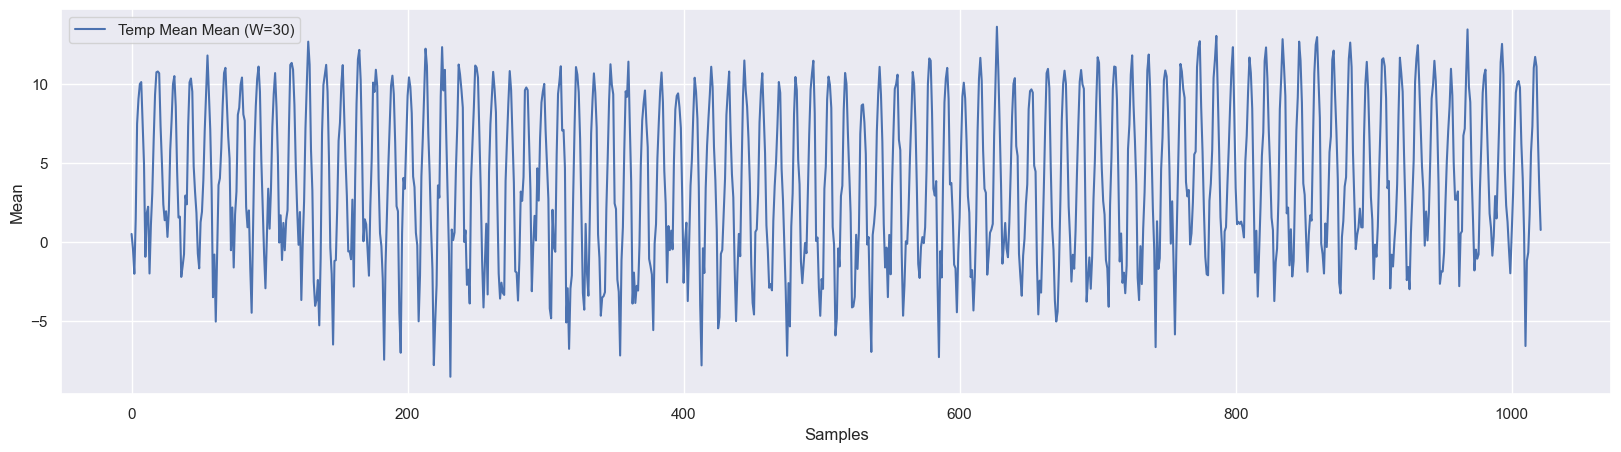

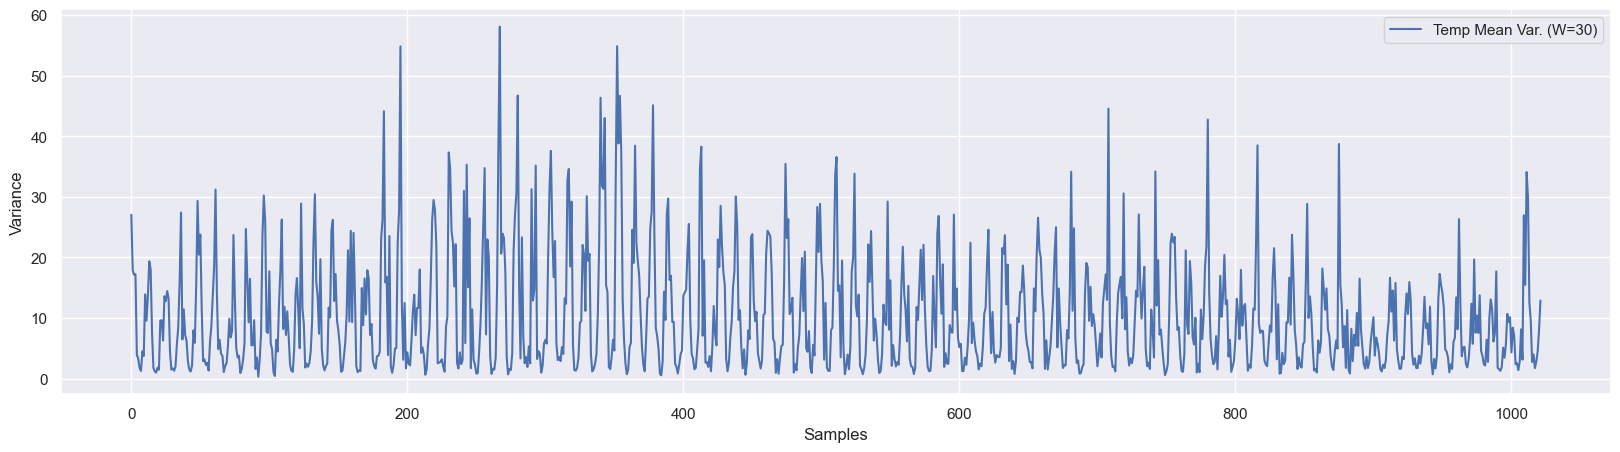

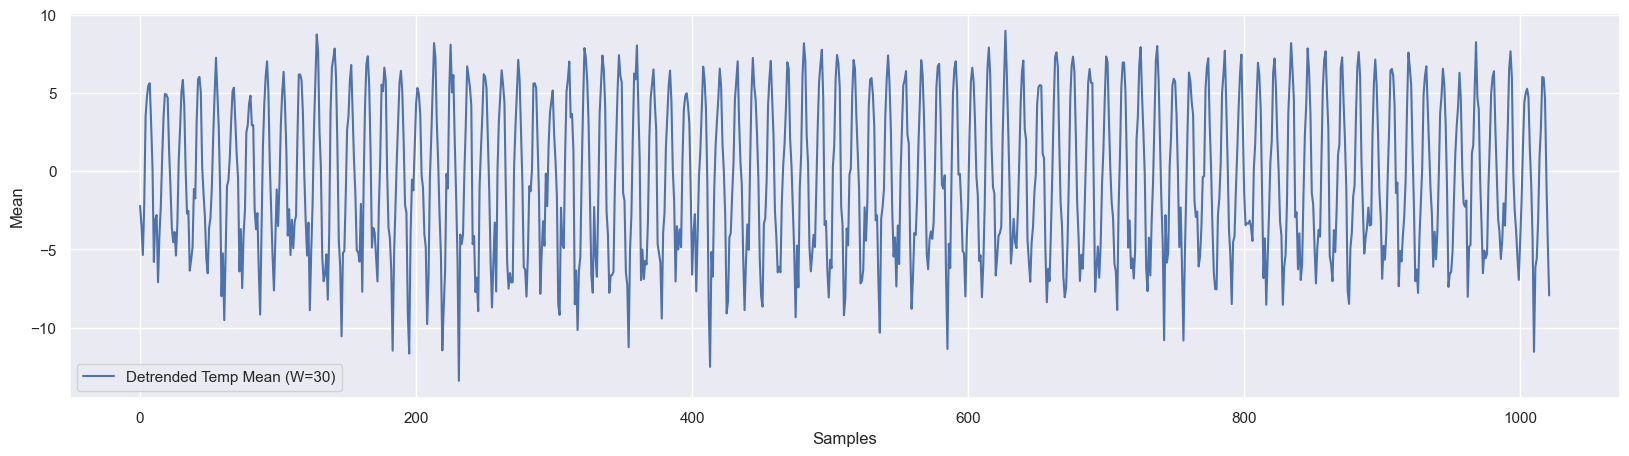

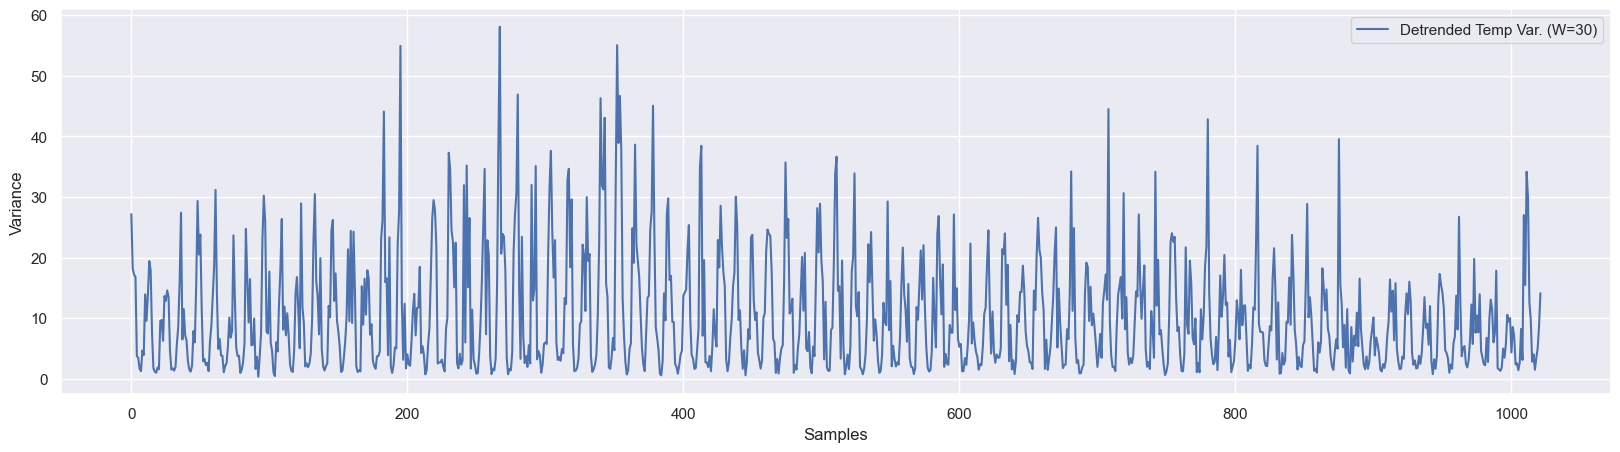

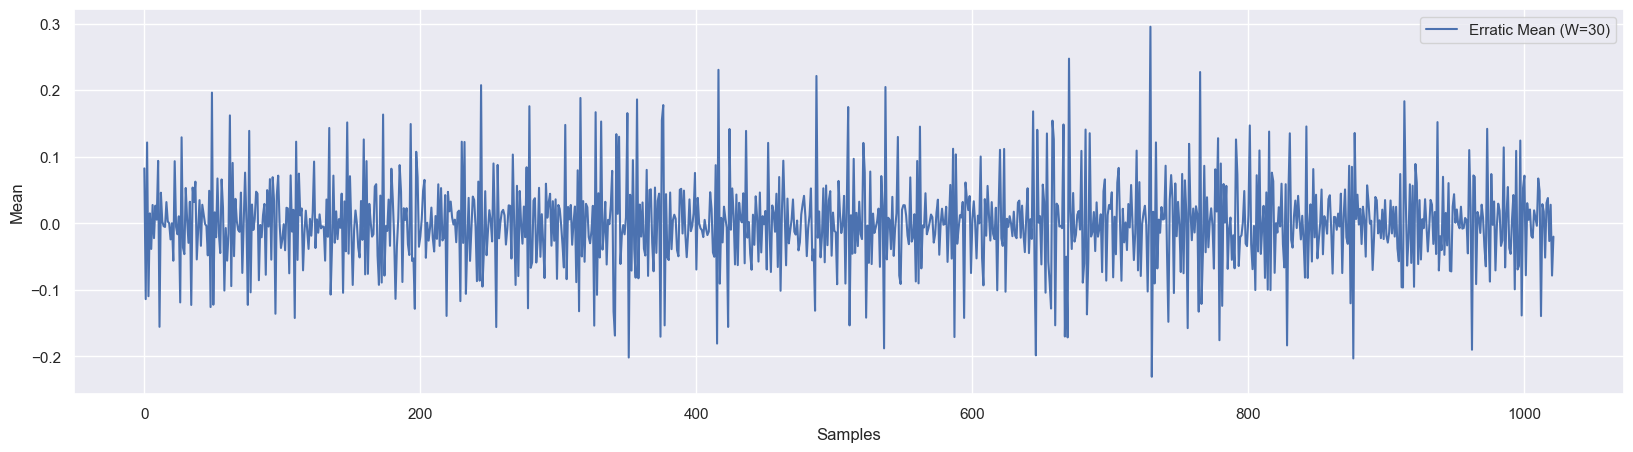

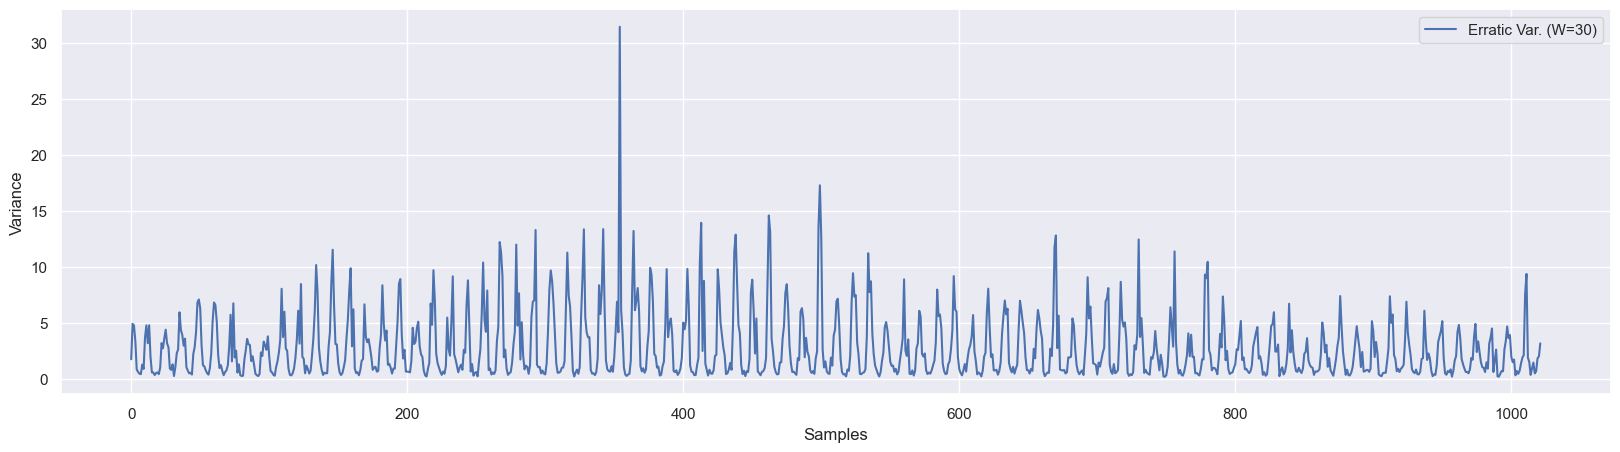

In [44]:
def meanvarWtime(timeseries,W=2):
    Nwin=int(np.floor(timeseries.size/W))
    vals=timeseries.to_numpy()
    vals=vals[0:int(Nwin*W)]
    mvals=vals.reshape((Nwin,W))
    return {'mu':np.mean(mvals,axis=1),'var':np.var(mvals,axis=1)}

fig, ax = plt.subplots(figsize=(20, 5))
Win=30 #Compute mean 
meanRandSeries=meanvarWtime(temp_mean,W=Win)['mu']
meanTS=pd.Series(data=meanRandSeries,index=np.array(range(meanRandSeries.size)),name="Temp Mean Mean (W="+str(Win)+")")
meanTS.plot(xlabel="Samples",ylabel="Mean",legend=True,ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
varRandSeries=meanvarWtime(temp_mean,W=Win)['var']
varTS=pd.Series(data=varRandSeries,index=np.array(range(varRandSeries.size)),name="Temp Mean Var. (W="+str(Win)+")")
varTS.plot(xlabel="Samples",ylabel="Variance",legend=True,ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
meanRandSeries=meanvarWtime(temp_mean_no_trend,W=Win)['mu']
meanTS=pd.Series(data=meanRandSeries,index=np.array(range(meanRandSeries.size)),name="Detrended Temp Mean (W="+str(Win)+")")
meanTS.plot(xlabel="Samples",ylabel="Mean",legend=True,ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
varRandSeries=meanvarWtime(temp_mean_no_trend,W=Win)['var']
varTS=pd.Series(data=varRandSeries,index=np.array(range(varRandSeries.size)),name="Detrended Temp Var. (W="+str(Win)+")")
varTS.plot(xlabel="Samples",ylabel="Variance",legend=True, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
meanRandSeries=meanvarWtime(temp_mean_no_trend_no_season,W=Win)['mu']
meanTS=pd.Series(data=meanRandSeries,index=np.array(range(meanRandSeries.size)),name="Erratic Mean (W="+str(Win)+")")
meanTS.plot(xlabel="Samples",ylabel="Mean",legend=True, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
varRandSeries=meanvarWtime(temp_mean_no_trend_no_season,W=Win)['var']
varTS=pd.Series(data=varRandSeries,index=np.array(range(varRandSeries.size)),name="Erratic Var. (W="+str(Win)+")")
varTS.plot(xlabel="Samples",ylabel="Variance",legend=True, ax=ax)
plt.show()


# Statistic Test ADFuller

ADF Statistic: -13.495728
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


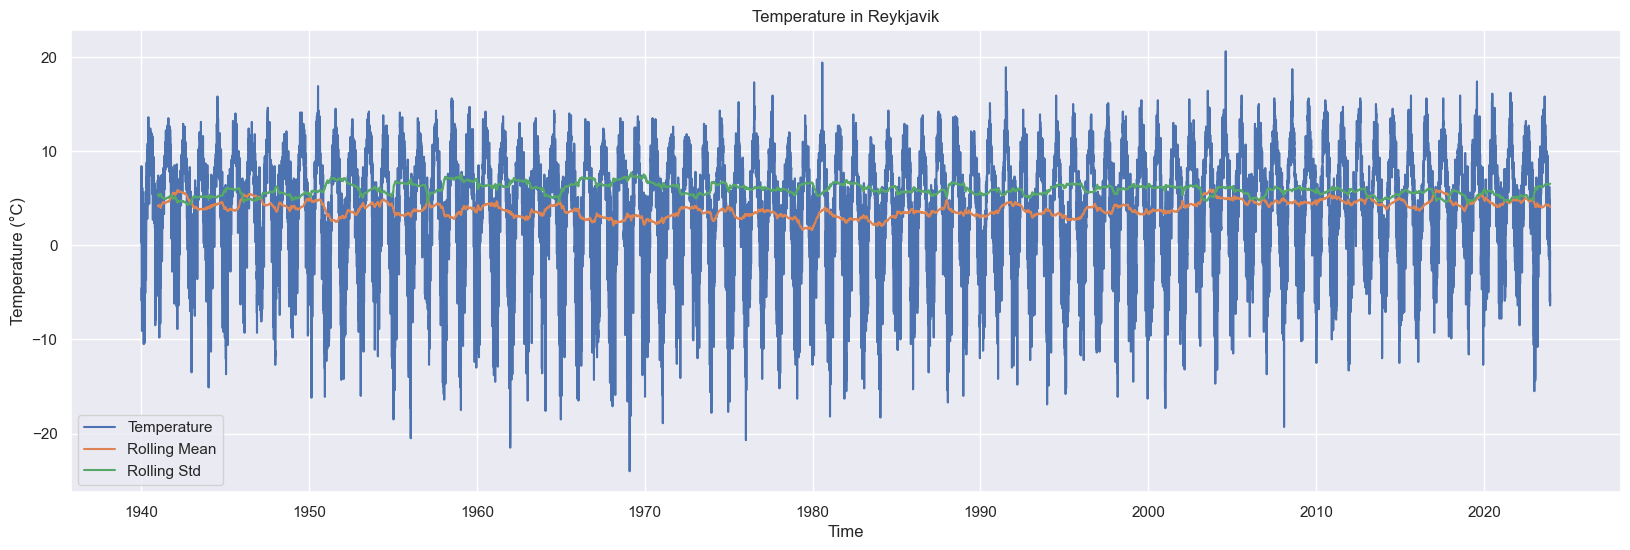

In [45]:
# Check if the time series is stationary
result = st.adfuller(temp_mean)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
# print results
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# Rolling mean and standard deviation
plt.figure(figsize=(20, 6))
plt.plot(time, temp_mean, label='Temperature')
plt.plot(time, temp_mean.rolling(window=365).mean(), label='Rolling Mean')
plt.plot(time, temp_mean.rolling(window=365).std(), label='Rolling Std')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in Reykjavik')
plt.show()


/var/folders/kb/_cpr8y_x64ngw7_s451m1qjw0000gn/T/ipykernel_30745/351742765.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = st.kpss(temp_mean)


KPSS Statistic: 0.215805
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


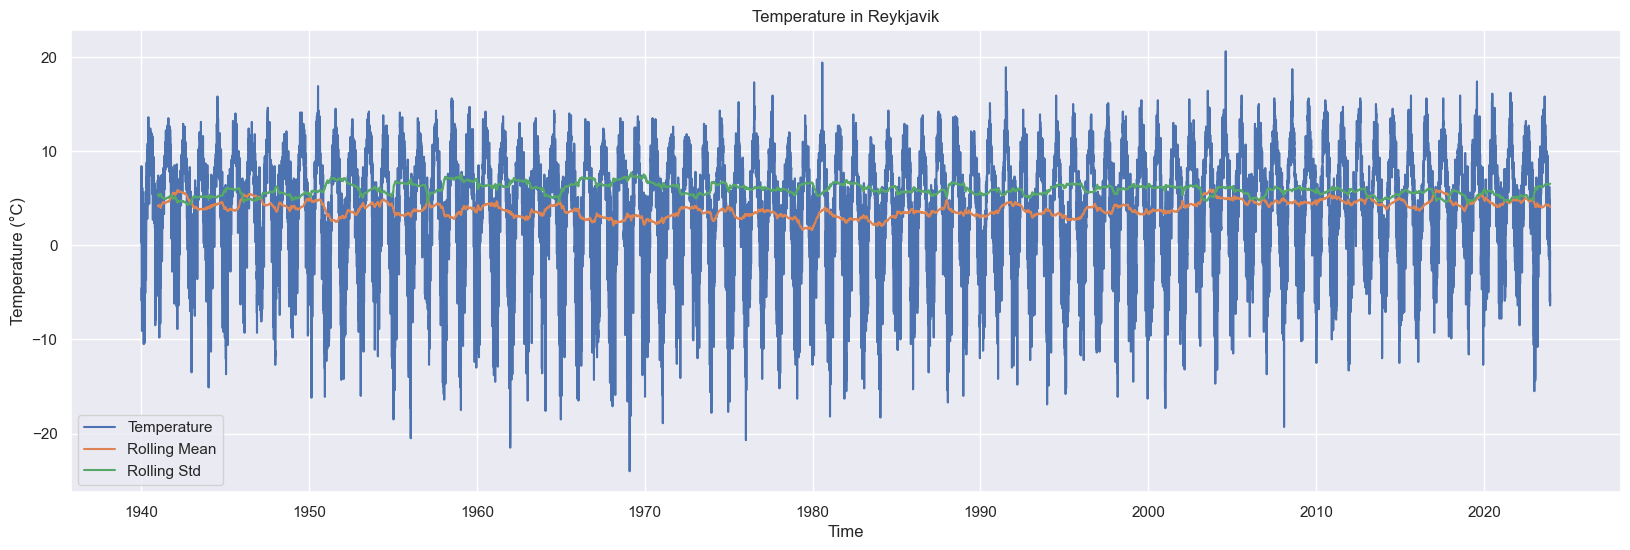

In [46]:
# apply KPSS test 
result = st.kpss(temp_mean)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
# print results
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

#plot
plt.figure(figsize=(20, 6))
plt.plot(time, temp_mean, label='Temperature')
plt.plot(time, temp_mean.rolling(window=365).mean(), label='Rolling Mean')
plt.plot(time, temp_mean.rolling(window=365).std(), label='Rolling Std')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in Reykjavik')
plt.show()


# SARIMA

We use SARIMA, as our data is non-stationary and also includes alot of seasonality.

For SARIMA implementation we follow the folloing order of processing : 
1. Evaluate the order of the model.
2. Remove the trend to get p value 
3. Plot the autocorrelation
4. to get the D component which is the seasonaly differencing order
 -> we get the 
    d=1 Trend, D=1 seasonality order ... for this usually we start with D=1
    S=360 cause the visible seasonality cycles are yearly .
5. to get q, we look at the samples destribuition in the partial autocorrelation and see at what point do we start to consider Zero autocorrleation, that point would be q.
6. Q = 1 in the class example cause it enters the missconfidance zone right after the first s =12 


-->   SARIMA (p,d,q) x (P,D,Q)


1. Estimate the model order

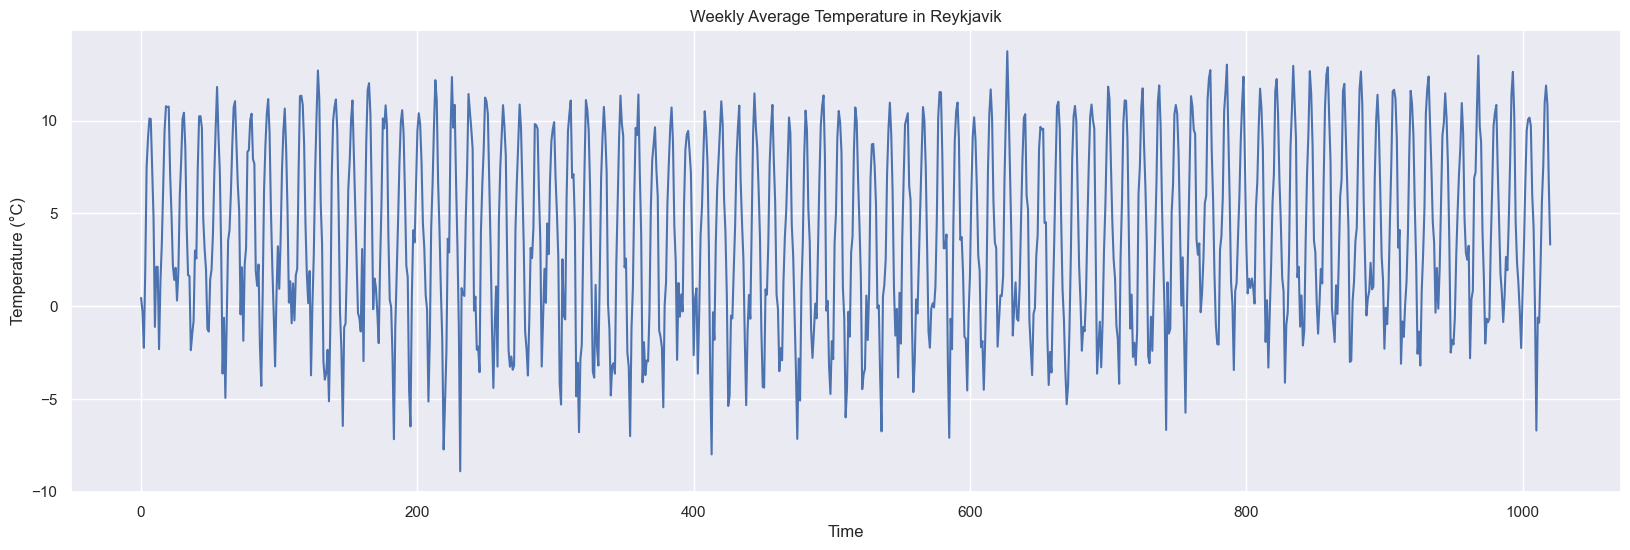

In [10]:
# get mean of every 7 steps to get weekly average then only take the mean of the first 84 yearsto simplify computations
monthly_mean = temp_mean.rolling(window=30,step=30).mean().dropna()

# change leftmost column to count up instead of steps of 7
monthly_mean.index = range(monthly_mean.size)

# plot weekly mean
plt.figure(figsize=(20, 6))
plt.plot(monthly_mean)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Weekly Average Temperature in Reykjavik')
plt.show()


Althoug the TS doesn't show much Trend it's important the remove even the slight trend that might occur

Text(84.875, 0.5, 'Autocorrelation')

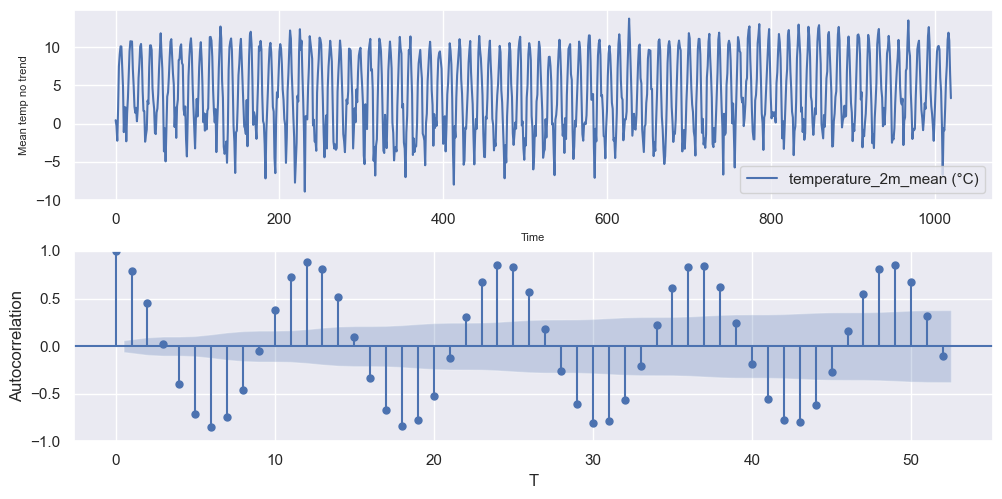

In [11]:
fig, axs=plt.subplots(2,figsize=(10,5))
fig.tight_layout()
monthly_mean.plot(ax=axs[0],legend=True)
axs[0].set_ylabel('Mean temp no trend',fontdict={'fontsize':8})
axs[0].set_xlabel('Time',fontdict={'fontsize':8})
plot_acf(monthly_mean,ax=axs[1],title='', lags=52)
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

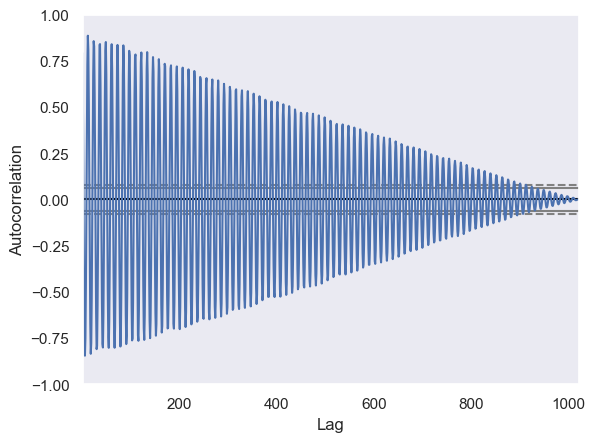

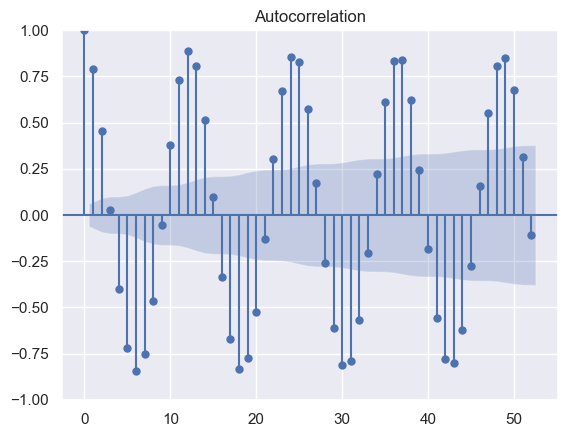

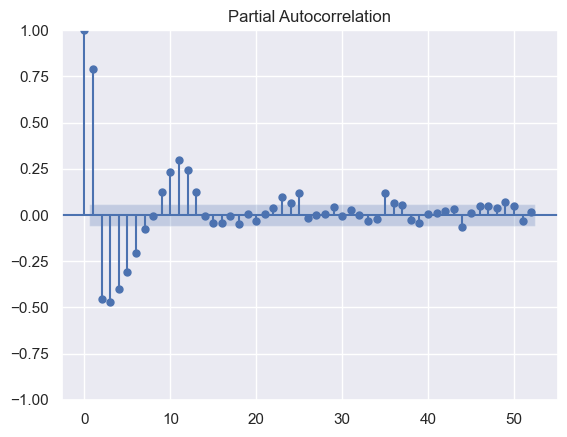

In [12]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
autocorrelation_plot(monthly_mean)
plot_acf(monthly_mean, lags=52)
plt.show()
plot_pacf(monthly_mean, lags=52)
plt.show()

In [14]:
import pmdarima as pmd

model=pmd.auto_arima(monthly_mean,start_p=1,start_q=1,m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=4318.960, Time=2.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6200.859, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4519.509, Time=0.77 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5100.193, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6675.473, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=4884.528, Time=0.82 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=4519.704, Time=1.12 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=4319.228, Time=9.33 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=4335.871, Time=8.88 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5083.897, Time=0.14 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=4789.281, Time=2.25 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=4379.483, Time=3.03 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=8.86 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=4330.275, Time=2.36 sec
 ARIMA(1,0,0)(1,0,1)[12]

# Multi-Variate

In [115]:
ts.columns

Index(['time', 'weather_code (wmo code)', 'temperature_2m_max (°C)',
       'temperature_2m_min (°C)', 'temperature_2m_mean (°C)',
       'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)',
       'apparent_temperature_mean (°C)', 'sunrise (iso8601)',
       'sunset (iso8601)', 'daylight_duration (s)', 'sunshine_duration (s)',
       'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'precipitation_hours (h)', 'wind_speed_10m_max (km/h)',
       'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
       'shortwave_radiation_sum (MJ/m²)', 'et0_fao_evapotranspiration (mm)'],
      dtype='object')

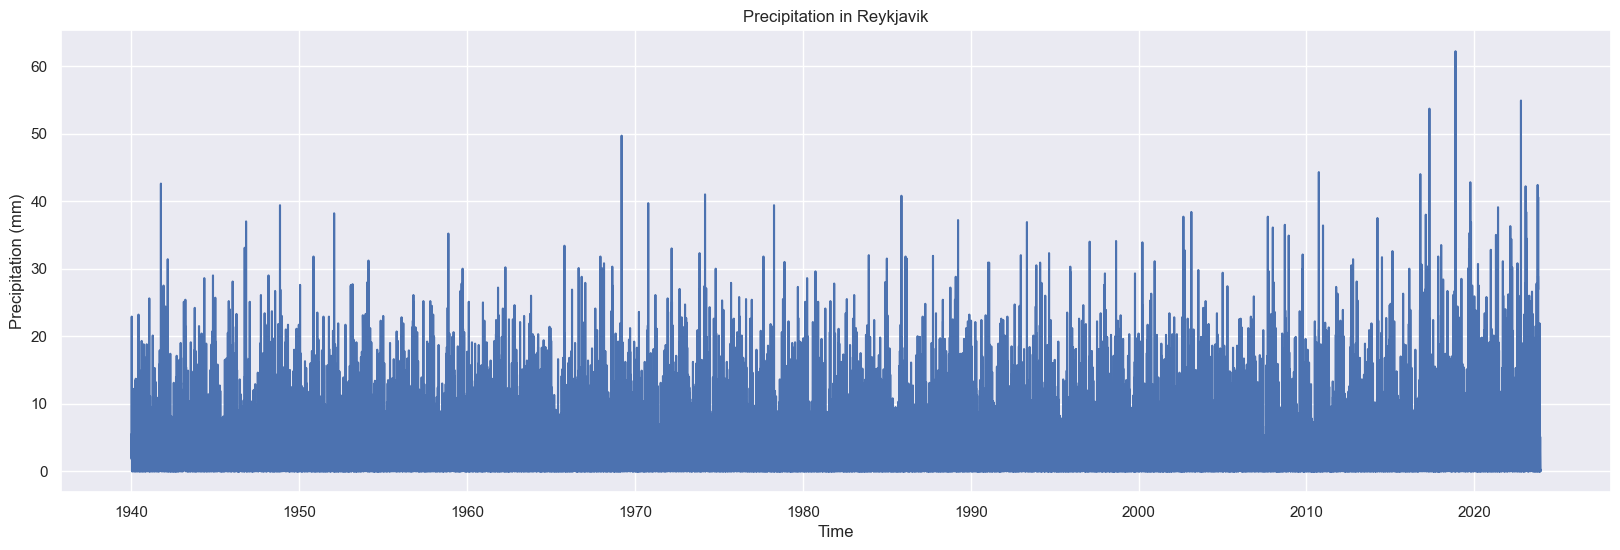

In [124]:
# import a second time series
precip_sum = ts['precipitation_sum (mm)'].iloc[:num_years*365]

# plot the time series
plt.figure(figsize=(20, 6))
plt.plot(time, precip_sum)
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation in Reykjavik')
plt.show()


Number of NaN values in precipitation: 1
Number of zero values in precipitation: 9066


/var/folders/kb/_cpr8y_x64ngw7_s451m1qjw0000gn/T/ipykernel_19412/2342787145.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precip_sum = precip_sum.fillna(method='ffill') # forward fill
/var/folders/kb/_cpr8y_x64ngw7_s451m1qjw0000gn/T/ipykernel_19412/2342787145.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precip_sum = precip_sum.fillna(method='bfill') # backward fill


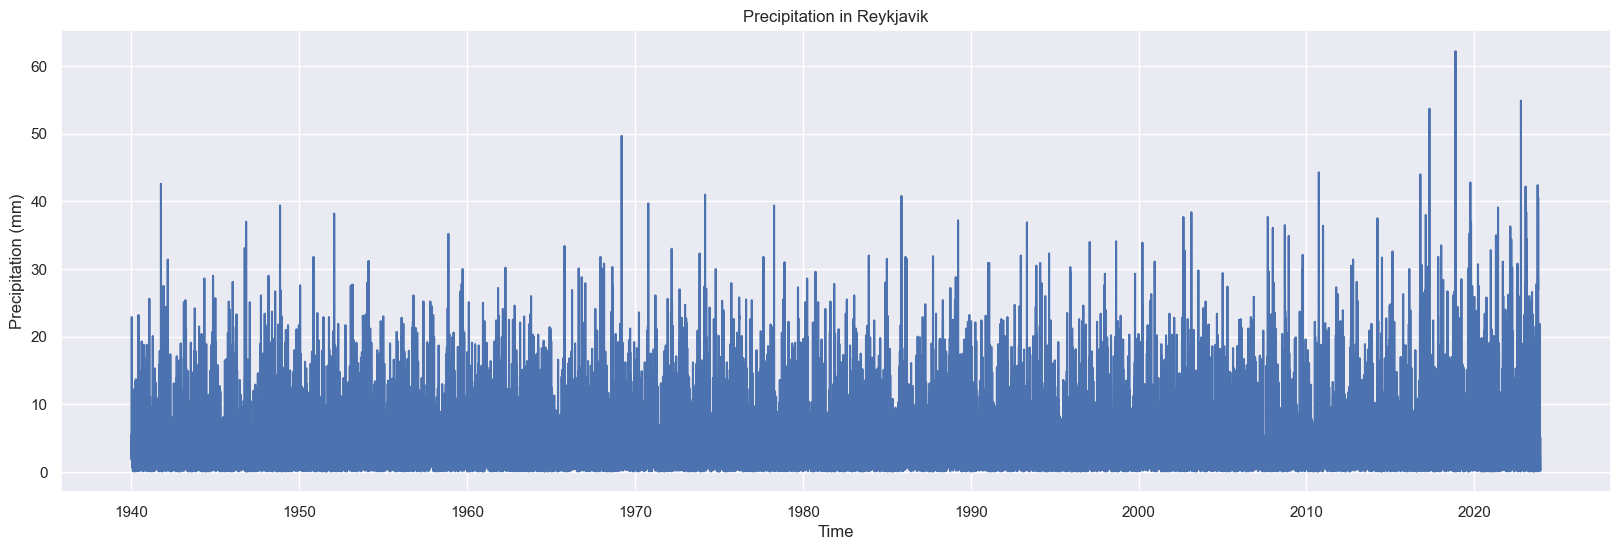

In [125]:
# count Nan values
print('Number of NaN values in precipitation:', precip_sum.isnull().sum())
# count zero values
print('Number of zero values in precipitation:', (precip_sum == 0).sum())

# replace zeros and missing values with the avg of the previous and next value
precip_sum = precip_sum.replace(0, np.nan)
precip_sum = precip_sum.fillna(method='ffill') # forward fill 
precip_sum = precip_sum.fillna(method='bfill') # backward fill

# plot the time series
plt.figure(figsize=(20, 6))
plt.plot(time, precip_sum)
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation in Reykjavik')
plt.show()




In [126]:
# count the 0 valus in the time serie
print('Number of zero values in precipitation:', (precip_sum == 0).sum())

# count nan values 
print('Number of NaN values in precipitation:', precip_sum.isnull().sum())

Number of zero values in precipitation: 0
Number of NaN values in precipitation: 0


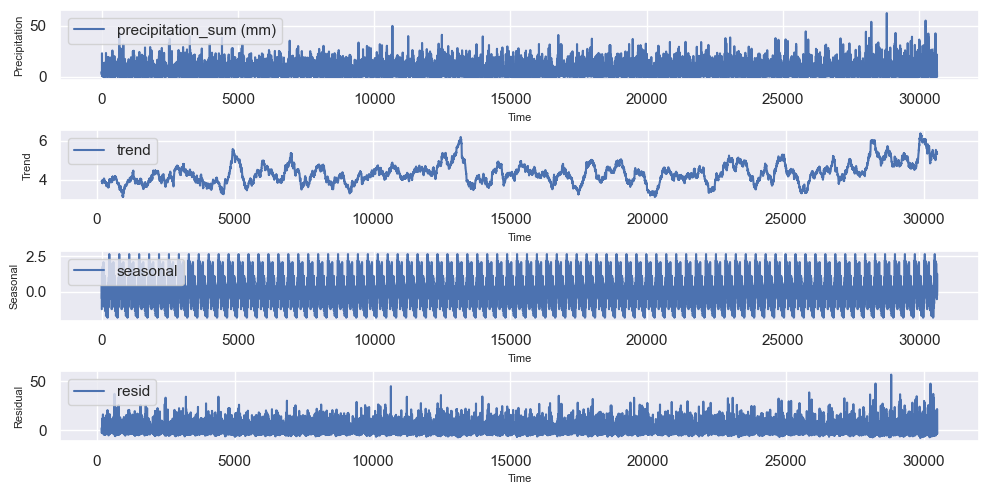

In [127]:
# decompose the time series precip_sum into trend, seasonal and residual components three
precip_sum_decomp = seasonal_decompose(precip_sum, model='additive', period=365)
precip_sum_trend = precip_sum_decomp.trend
precip_sum_seasonal = precip_sum_decomp.seasonal
precip_sum_residual = precip_sum_decomp.resid

# plot the decomposed time series
fig, axs = plt.subplots(4,figsize=(10,5))
fig.tight_layout()
precip_sum.plot(ax=axs[0],legend=True)
axs[0].set_ylabel('Precipitation',fontdict={'fontsize':8})
axs[0].set_xlabel('Time',fontdict={'fontsize':8})
precip_sum_trend.plot(ax=axs[1],legend=True)
axs[1].set_ylabel('Trend',fontdict={'fontsize':8})
axs[1].set_xlabel('Time',fontdict={'fontsize':8})
precip_sum_seasonal.plot(ax=axs[2],legend=True)
axs[2].set_ylabel('Seasonal',fontdict={'fontsize':8})
axs[2].set_xlabel('Time',fontdict={'fontsize':8})
precip_sum_residual.plot(ax=axs[3],legend=True)
axs[3].set_ylabel('Residual',fontdict={'fontsize':8})
axs[3].set_xlabel('Time',fontdict={'fontsize':8})
plt.show()



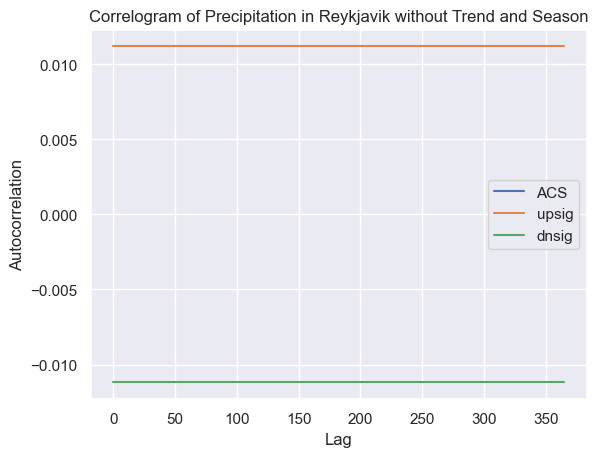

In [121]:
# calcualte the autocorrelation of the precipitation time series

precip_sum_no_trend = precip_sum - precip_sum_trend

precip_sum_no_trend_no_season = precip_sum_no_trend - precip_sum_seasonal

correlogram(precip_sum,365).plot()
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of Precipitation in Reykjavik')
plt.show()

# Autocorrelation of precip_sum without trend
correlogram(precip_sum_no_trend,365).plot()
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of Precipitation in Reykjavik without Trend')
plt.show()


# Autocorrelation of precip_sum without trend and season
correlogram(precip_sum_no_trend_no_season,365).plot()
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of Precipitation in Reykjavik without Trend and Season')
plt.show()

### Cross-correlation

In [76]:

# calcaulte the cross covariance of the two time series
def crosscov(timeserie1,timeserie2,T=0):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    mu1=timeserie1.mean()
    mu2=timeserie2.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie1[n]-mu1)*(timeserie2[n+T]-mu2)
    return covCoef/float(np.abs(N))

def crosscoef(timeserie1,timeserie2,T=0):
    s1=timeserie1.std()
    s2=timeserie2.std()
    return crosscov(timeserie1,timeserie2,T)/(s1*s2)

def ccs(timeserie1,timeserie2,maxT,twoside=False):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            if i==0:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
            else:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
                corrl[maxT-i]=crosscoef(timeserie2,timeserie1,i);
        else:
            corrl[i]=crosscoef(timeserie1,timeserie2,i);
    d = {'CCS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),
         'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl


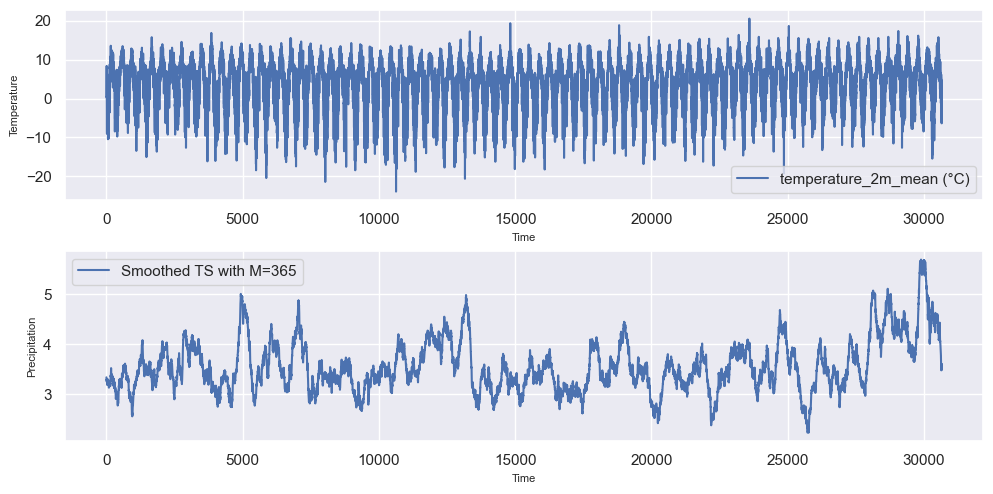

In [77]:
# plot both time series in two separate plots
fig, axs = plt.subplots(2,figsize=(10,5))
fig.tight_layout()
temp_mean.plot(ax=axs[0],legend=True)
axs[0].set_ylabel('Temperature',fontdict={'fontsize':8})
axs[0].set_xlabel('Time',fontdict={'fontsize':8})
precip_sum.plot(ax=axs[1],legend=True)
axs[1].set_ylabel('Precipitation',fontdict={'fontsize':8})
axs[1].set_xlabel('Time',fontdict={'fontsize':8})
plt.show()


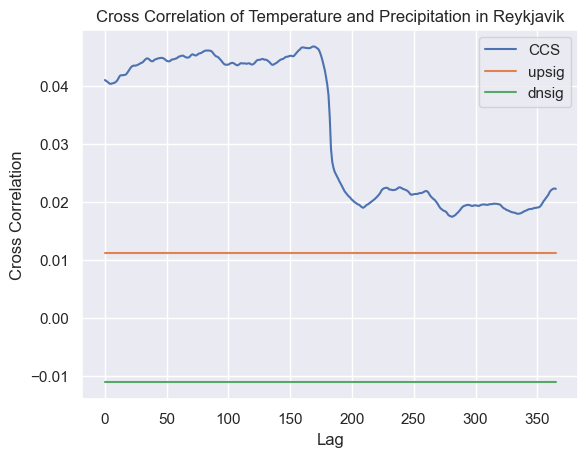

/var/folders/kb/_cpr8y_x64ngw7_s451m1qjw0000gn/T/ipykernel_19412/1376715835.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  covCoef=covCoef+(timeserie1[n]-mu1)*(timeserie2[n+T]-mu2)


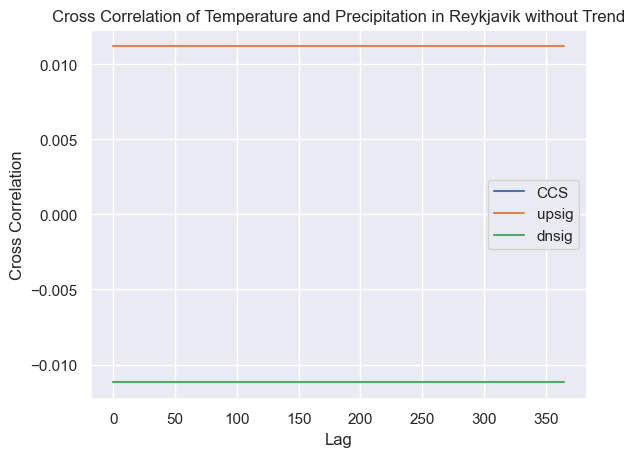

/var/folders/kb/_cpr8y_x64ngw7_s451m1qjw0000gn/T/ipykernel_19412/1376715835.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  covCoef=covCoef+(timeserie1[n]-mu1)*(timeserie2[n+T]-mu2)


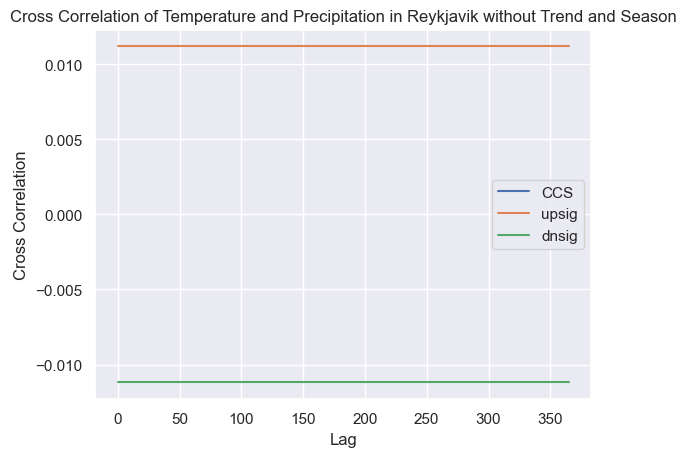

In [78]:
# calculat the cross-corrlation of the two time series
ccs(temp_mean,precip_sum,365).plot()
plt.xlabel('Lag')
plt.ylabel('Cross Correlation')
plt.title('Cross Correlation of Temperature and Precipitation in Reykjavik')
plt.show()

# calculate the cross-correlation of the two time series without trend
ccs(temp_mean_no_trend,precip_sum_no_trend,365).plot()
plt.xlabel('Lag')
plt.ylabel('Cross Correlation')
plt.title('Cross Correlation of Temperature and Precipitation in Reykjavik without Trend')
plt.show()

# calculate the cross-correlation of the two time series without trend and season
ccs(temp_mean_no_trend_no_season,precip_sum_no_trend_no_season,365).plot()
plt.xlabel('Lag')
plt.ylabel('Cross Correlation')
plt.title('Cross Correlation of Temperature and Precipitation in Reykjavik without Trend and Season')
plt.show()

